# Summary
<br>
Code based on https://journals.aps.org/pra/pdf/10.1103/PhysRevA.69.032305
<br> Calculating what the theoretical p_34 value is
<br> 

---

In [2]:
import qutip
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

In [3]:
from scipy.optimize import curve_fit

In [4]:
def fit_func(x, a, b):
    return b + (1/(1+(a*x)))

In [5]:
cav_dim = 2

g = 1                #gamma
rg = np.sqrt(g)


t_final = 5
tau_final = 10
res = 100
step = min(t_final, tau_final)/res
t_time = np.arange(0, t_final, step)
tau_time = np.arange(0, tau_final, step)

c = qutip.destroy(cav_dim)
H = qutip.qeye(cav_dim)
psi_0 = qutip.fock(cav_dim, 1)
#psi_0 = 0.7*qutip.fock_dm(cav_dim,1) + 0.3*qutip.fock_dm(cav_dim,0) + qutip.sigmay()
#psi_0 = qutip.qeye(cav_dim)/2

In [15]:
def G_34_matrix(H, psi0, t, tau, L_list, step):
    corel = qutip.correlation_2op_2t(H, psi0, t, tau, L_list, c.dag(), c)
    corel_er = qutip.correlation_3op_2t(H, psi0, t, tau, L_list, c.dag(), c.dag()*c, c)
    result = qutip.mesolve(H, psi0, np.arange(0, t[-1]+tau[-1]+2*step , step), L_list, [qutip.fock_dm(cav_dim,1), ] )  

    sigmaee_t = np.zeros_like(corel)
    sigmaee_t_tau = np.zeros_like(corel)

    x_dim, y_dim = corel.shape
    #t, tau
    for i in range(y_dim):
        sigmaee_t[:,i] =  result.expect[0][:x_dim]
        sigmaee_t_tau[:,i] = result.expect[0][i:i+x_dim]

    p_34_denom = sigmaee_t*sigmaee_t_tau
    G_t_tau = (p_34_denom) - ((corel)**2)
    G_t_tau *= 0.5  
    #G_t_tau += 0.5 * corel_er
    #G_t_tau = corel_er + corel**2     #for test 1/1+4x fit
    p_34_denom = np.sum(p_34_denom) * step * step
    G_t_tau /= p_34_denom
    t_int = [step*sum(i) for i in G_t_tau.T]
    p_34 = sum(t_int) * step

    

    return p_34, t_int

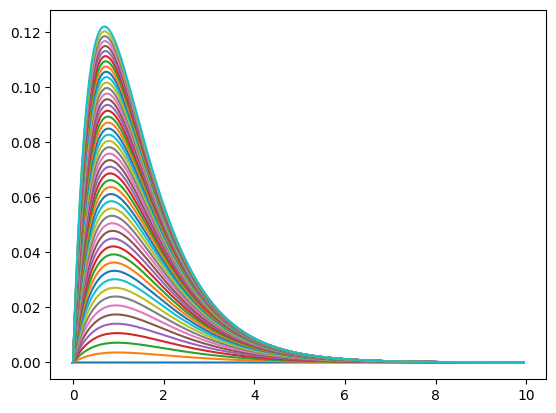

In [16]:
p_34_list = list()
deph_list = np.linspace(0,g/4,50)
for deph in deph_list:
    
    L_list = [rg*c, np.sqrt(deph)*qutip.sigmaz()]
    p_34, t_int = G_34_matrix(H, psi_0, t_time, tau_time, L_list, step)
    p_34_list.append(p_34)
    plt.plot(tau_time, t_int)
#plt.legend([0.01*int(i*100) for i in deph_list])

In [17]:
params = curve_fit(fit_func, deph_list,  np.real(1 - np.array(p_34_list)))

In [18]:
params

(array([ 1.25441338, -0.01904908]),
 array([[7.02531228e-04, 6.05861677e-05],
        [6.05861677e-05, 6.47589503e-06]]))

In [19]:
g

1

/Users/ygup3491/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, '1 - $p_{34}$')

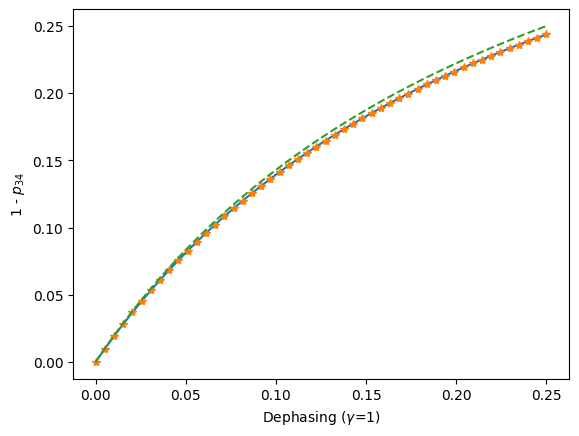

In [25]:
a = plt.plot(deph_list, np.array(p_34_list) )
plt.plot(deph_list,  np.array(p_34_list) ,'*')
plt.plot(deph_list, 0.5 - (0.5)/(1+(4*deph_list/g))  ,'--')
#plt.legend(['','',r'$\dfrac{1}{1+ \alpha x}$'])
#plt.xscale('log')

plt.xlabel("Dephasing ($\gamma$=1)")
plt.ylabel("1 - $p_{34}$")

In [42]:
#plt.plot([sum(i) for i in sigmaee_t.T])
#plt.plot(c_time, sigmaee_t.T[0])

#plt.plot
#sum((sigmaee_t.T)[0])
#plt.plot(([sum(i) for i in sigmaee_t_tau.T]))
#plt.plot(([sum(i) for i in (corel**2).T]), 'o')
#plt.plot(([sum(i) for i in ((sigmaee_t_tau*sigmaee_t)).T]))
#plt.plot(([sum(i) for i in ((sigmaee_t_tau*sigmaee_t) - corel**2).T]))

In [327]:
deph = 0.1
L_list = [rg*c, np.sqrt(deph)*qutip.sigmaz()]

corel = qutip.correlation_2op_2t(H, psi_0, t_time, tau_time, L_list, c.dag(), c)
#corel_er = qutip.correlation_3op_2t(H, psi0, t, tau, L_list, c.dag(), c.dag()*c, c)
#result = qutip.mesolve(H, psi0, np.arange(0, t[-1]+tau[-1]+2*step , step), L_list, [qutip.fock_dm(cav_dim,1), ] )  

analytic_corel = np.zeros_like(corel)
for i in range(len(t_time)):
    for j in range(len(tau_time)):
        analytic_corel[i,j] = np.exp(-1*((0.5*g)+(2*deph))*tau_time[j]) * np.exp(-g*t_time[i])
        #analytic_corel[i,j] = np.exp(-g*tau_time[j]) * np.exp(-g*t_time[i])

'''
sigmaee_t = np.zeros_like(corel)
sigmaee_t_tau = np.zeros_like(corel)

x_dim, y_dim = corel.shape
#t, tau
for i in range(y_dim):
    sigmaee_t[:,i] =  result.expect[0][:x_dim]
    sigmaee_t_tau[:,i] = result.expect[0][i:i+x_dim]

p_34_denom = sigmaee_t*sigmaee_t_tau
#G_t_tau = (p_34_denom) - ((corel)**2)
#G_t_tau *= 0.5  
#G_t_tau += 0.5 * corel_er
G_t_tau = corel_er + corel**2
p_34_denom = np.sum(p_34_denom) * step * step
G_t_tau /= p_34_denom
t_int = [step*sum(i) for i in G_t_tau.T]
p_34 = sum(t_int) * step
'''

'\nsigmaee_t = np.zeros_like(corel)\nsigmaee_t_tau = np.zeros_like(corel)\n\nx_dim, y_dim = corel.shape\n#t, tau\nfor i in range(y_dim):\n    sigmaee_t[:,i] =  result.expect[0][:x_dim]\n    sigmaee_t_tau[:,i] = result.expect[0][i:i+x_dim]\n\np_34_denom = sigmaee_t*sigmaee_t_tau\n#G_t_tau = (p_34_denom) - ((corel)**2)\n#G_t_tau *= 0.5  \n#G_t_tau += 0.5 * corel_er\nG_t_tau = corel_er + corel**2\np_34_denom = np.sum(p_34_denom) * step * step\nG_t_tau /= p_34_denom\nt_int = [step*sum(i) for i in G_t_tau.T]\np_34 = sum(t_int) * step\n'